In [1]:
from sklearn.datasets import load_files
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from string import digits
import h5py
import pydot
from collections import Counter
from IPython.display import SVG

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

%matplotlib inline

In [3]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


# Import the data

In [4]:
#IMPORT TRAINING DATA
reviews_train = load_files("aclImdb/train/", shuffle=False, encoding='utf-8')
text_train, y_train = reviews_train.data, reviews_train.target

In [5]:
#IMPORT TESTING DATA
reviews_test = load_files("aclImdb/test/", shuffle=False, encoding='utf-8')
text_test, y_test = reviews_test.data, reviews_test.target

In [6]:
print("Number of documents in train data: {}".format(len(text_train)))
print("Samples per class (train): {}".format(np.bincount(y_train)))

print("Number of documents in test data: {}".format(len(text_test)))
print("Samples per class (test): {}".format(np.bincount(y_test)))

Number of documents in train data: 25000
Samples per class (train): [12500 12500]
Number of documents in test data: 25000
Samples per class (test): [12500 12500]


# Clean Text Data

In [7]:
# 1.Define the characters to be removed. 
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]_0-9]") # Removes : . ; : ! ' ? , " ( ) [ ] _ and digits (0-9) 
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)") #removes html tags

# 2.Define stop words to be removed
#stop_words = stopwords.words('english') 
#Default stop words above might be removing too much words. Therefore I copied it and removed some words that
#I thought would be useful. Feel free to add/remove.
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',"you're", "you've", "you'll",
              "you'd", 'your', 'yours', 'yourself','yourselves', 'he', 'him', 'his', 'himself', 'she', "she's",
              'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 
              'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those',
              'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do',
              'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'if', 'or', 'because', 'as', 'until',
              'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during',
              'before', 'after', 'to', 'from', 'further', 'then', 'once', 'here', 'there', 'when','where',
              'why', 'how', 'all','both', 'each', 'few',  'such','own', 'same', 'so', 'can', 'will', 'just',
              'now', 'd', 'll', 'm', 'o', 're', 've', 'y']

In [8]:
def cleanText(text_train):
    # 3.remove REPLACE_NO_SPACE characters and convert all charachters to low-case
    text_train = [REPLACE_NO_SPACE.sub("", line.lower()) for line in text_train]
    
    # 4.remove REPLACE_WITH_SPACE characters by replacing them with space
    text_train = [REPLACE_WITH_SPACE.sub(" ", line) for line in text_train]
    
    #remove stop words
    removed_stop_words = []
    for review in text_train:
        removed_stop_words.append(' '.join([word for word in review.split() 
        if word not in stop_words]))
        
    text_train = removed_stop_words
    
    # 5. Word normalization: stemmization or lemmatization. They are practically trying to convert the words into
    #their origins. Stemmmers just chop-off certain parts from the ends of the words, therefore they are mostly 
    #considered as very aggresssive. Lemmatizers are more complex and they sort of try to find the origin of the
    #words rather than chopping off the end (i.e. "am", "is", "are" would be converted into "be") 
    # Make sure that you use either stemmizer or lemmatizer. Using both of them could result in distortion of 
    #the data.
              
    # 5a. stemmize: there are two stemmizer options
    
    #stemmer = PorterStemmer()
    #stemmer = LancasterStemmer()
    #text_train =  [' '.join([stemmer.stem(word) for word in review.split()]) for review in text_train]
    
    # 5b. lemmatize
    lemmatizer = WordNetLemmatizer()
    text_train = [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in text_train]

    
    return text_train

In [9]:
cleanedTrainingText = cleanText(text_train)
cleanedTestingText = cleanText(text_test)

In [10]:
# You can see the result of cleaning here. Check different reviews by changing the reviewNo
reviewNo = 202 #an integer from 0 to 24999
print("Before: ")
print(text_train[reviewNo])
print(" ")
print("After: ")
print(cleanedTrainingText[reviewNo])

Before: 
Okay, just by reading the title you would think that it would be a good movie. Well, at least I did. It started out good but became so boring after the first half hour. *spoiler*<br /><br />It tells a story about a mother that is so desperate for her daughter to become a cheerleader that she will go to any lengths to get what she wants. The only problem is that her daughter's friend is the girl in the way. She always wins the competitions, therefore pushing the mother further towards "eliminating" her. After talking to a "hitman", the mother decides that the girl needs to be roughed up a bit. So actions are taken but she eventually gets caught.<br /><br />The cast is awful and the movie drags on too long with nothing happening. Don't waste your time watching this.<br /><br />
 
After: 
okay reading title would think would good movie well least started out good but became boring first half hour *spoiler* tell story mother desperate daughter become cheerleader go any length get 

# Dictionary to map from word to integer

In [11]:
All_text = cleanedTrainingText + cleanedTestingText
All_words = ' '.join(All_text)
All_words = All_words.split()

In [12]:
words_count = Counter(All_words)
# Set of keys, which is sorted based on the values 
sorted_set_of_words = sorted(words_count, key = words_count.get, reverse = True)
vocab_to_int = {w: idx+1 for idx, w in enumerate(sorted_set_of_words)}
int_to_vocab = {idx+1: w for idx, w in enumerate(sorted_set_of_words)}

# When key is 0, return '' for padding sequence
vocab_to_int[''] = 0
int_to_vocab[0] = ''

# Define the maximum number of words we want to work with

In [13]:
max_features = 8000

In [14]:
train_int = [[vocab_to_int[w]  for w in review.split() if vocab_to_int[w]<max_features] for review in cleanedTrainingText]
test_int = [[vocab_to_int[w]  for w in review.split() if vocab_to_int[w]<max_features] for review in cleanedTestingText]

In [15]:
x_train, x_test = train_int, test_int

In [16]:
def print_comments(x,loc):
    print(' '.join(int_to_vocab[id] for id in x[loc]))

In [17]:
print_comments(x_train,202)

okay reading title would think would good movie well least started out good but became boring first half hour tell story mother desperate daughter become cheerleader go any length get want only problem daughter friend girl in way always win competition therefore pushing mother towards talking mother decides girl need up bit action taken but eventually get caught cast awful movie drag on too long nothing happening dont waste time watching


# Padding sequence such that all reviews have the same length

In [18]:
maxlen = 600

In [19]:
print('Pad sequences:')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences:
x_train shape: (25000, 600)
x_test shape: (25000, 600)


In [20]:
print_comments(x_train,202)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 okay reading title would think would good movie well least started out good but became boring first half hour tell story mother desperate daughter become cheerleader go any length get want only problem daughter friend girl in way always win competition therefore pushing mother towards talking mother decides girl need up bit action taken but eventually get caught cast awful movie drag on too long nothing happening dont waste time watching


# RNN model

In [21]:
batch_size = 25

In [22]:
model = Sequential()
model.add(Embedding(max_features, 50, name='HT_embedding'))
model.add(LSTM(128, dropout=0.3))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
HT_embedding (Embedding)     (None, None, 50)          400000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 508,289
Trainable params: 508,289
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
RNN_checkpoint = ModelCheckpoint('RNN-model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', 
                             verbose=1, 
                             monitor='val_loss',
                             save_best_only=True, 
                             mode='auto')

In [26]:
history_RNN = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          callbacks=[RNN_checkpoint],
          validation_data=(x_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 639s 26ms/step - loss: 0.3912 - acc: 0.8216 - val_loss: 0.3090 - val_acc: 0.8736

Epoch 00001: val_loss improved from inf to 0.30897, saving model to RNN-model-001-0.821560-0.873560.h5
Epoch 2/10
25000/25000 [==============================] - 629s 25ms/step - loss: 0.2484 - acc: 0.9046 - val_loss: 0.3660 - val_acc: 0.8530

Epoch 00002: val_loss did not improve from 0.30897
Epoch 3/10
25000/25000 [==============================] - 643s 26ms/step - loss: 0.1915 - acc: 0.9288 - val_loss: 0.4315 - val_acc: 0.8589

Epoch 00003: val_loss did not improve from 0.30897
Epoch 4/10
25000/25000 [==============================] - 636s 25ms/step - loss: 0.1509 - acc: 0.9454 - val_loss: 0.3797 - val_acc: 0.8375

Epoch 00004: val_loss did not improve from 0.30897
Epoch 5/10
25000/25000 [==============================] - 641s 26ms/step - loss: 0.130

In [27]:
#model.save('RNN_model_latest.h5')
#del model
#model = load_model('RNN_model_latest.h5')

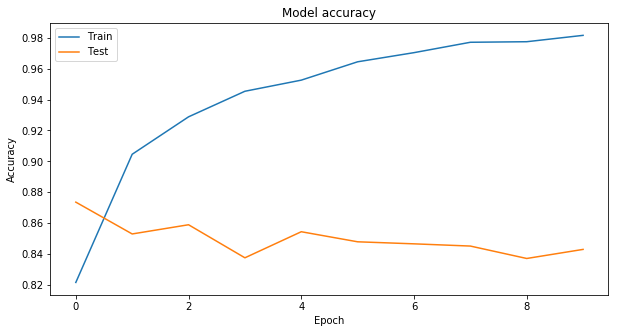

In [104]:
history = history_RNN
plt.figure(figsize=(10,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [29]:
#model = load_model('RNN_best_model.h5')

In [30]:
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [31]:
#plot_model(model, to_file='RNN_best_model.png')

# Extract the embeded layer to print out words with close meaning

In [68]:
# Load the best model
model_RNN = load_model('RNN-model-001-0.821560-0.873560.h5')

In [69]:
# get embedding layer out of the model
layer_embedding_RNN = model_RNN.get_layer('HT_embedding')
weights_embedding_RNN = layer_embedding_RNN.get_weights()[0]
weights_embedding_RNN.shape

(8000, 50)

In [33]:
def print_sorted_words(word, weights_embedding = weights_embedding_RNN, metric='cosine', k = 10):
    # take out the word we care
    token = vocab_to_int[word]
    embedding = weights_embedding[token]
    
    #calculate the distances from the words
    distances = cdist(weights_embedding, [embedding],
                      metric=metric)
    distances = np.ravel(distances)
    
    sorted_index = np.argsort(distances)
    
    # Calculate the distances and words
    sorted_distances = distances[sorted_index[:k]]
    sorted_words = [int_to_vocab[idx] for idx in sorted_index[:k]]
    
    print("Distance from '{0}':".format(word))
    for word, distance in zip(sorted_words, sorted_distances):
            print("{0:.3f} - {1}".format(distance, word))

In [120]:
print_sorted_words('perfect',weights_embedding = weights_embedding_RNN, metric='cosine', k = 6)

Distance from 'perfect':
0.000 - perfect
0.071 - quirk
0.075 - excellent
0.083 - reservation
0.085 - wonderfully
0.085 - flawless


In [121]:
print_sorted_words('boring', weights_embedding = weights_embedding_RNN, metric='cosine', k = 6)

Distance from 'boring':
0.000 - boring
0.050 - worst
0.062 - boredom
0.063 - pointless
0.069 - incoherent
0.072 - skull


# CNN model

In [36]:
batch_size = 25
kernel_size = 3

In [37]:
model = Sequential()

model.add(Embedding(max_features,100,
                    input_length=maxlen,
                    name = 'HT_embedding'))
model.add(Dropout(0.2))
model.add(Conv1D(500,kernel_size,padding='valid',
                 activation='relu',strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(500,activation ='relu'))
model.add(Dropout(0.5))
model.add(Dense(250,activation ='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
HT_embedding (Embedding)     (None, 600, 100)          800000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 600, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 598, 500)          150500    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 250)               125250    
__________

In [39]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
CNN_checkpoint = ModelCheckpoint('CNN-model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', 
                             verbose=1, 
                             monitor='val_loss',
                             save_best_only=True, 
                             mode='auto')

In [41]:
history_CNN = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          callbacks=[CNN_checkpoint],
          validation_data=(x_test, y_test))

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 530s 21ms/step - loss: 0.4200 - acc: 0.7924 - val_loss: 0.2954 - val_acc: 0.8763

Epoch 00001: val_loss improved from inf to 0.29540, saving model to CNN-model-001-0.792360-0.876320.h5
Epoch 2/10
25000/25000 [==============================] - 547s 22ms/step - loss: 0.2250 - acc: 0.9139 - val_loss: 0.2800 - val_acc: 0.8851

Epoch 00002: val_loss improved from 0.29540 to 0.27998, saving model to CNN-model-002-0.913880-0.885120.h5
Epoch 3/10
25000/25000 [==============================] - 563s 23ms/step - loss: 0.1271 - acc: 0.9536 - val_loss: 0.3257 - val_acc: 0.8773

Epoch 00003: val_loss did not improve from 0.27998
Epoch 4/10
25000/25000 [==============================] - 555s 22ms/step - loss: 0.0731 - acc: 0.9737 - val_loss: 0.4270 - val_acc: 0.8705

Epoch 00004: val_loss did not improve from 0.27998


In [ ]:
model.save('CNN_model_latest.h5')

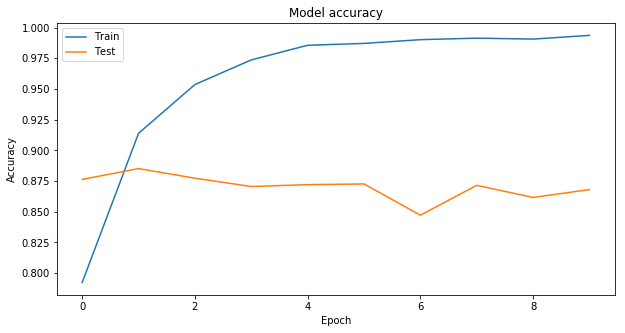

In [103]:
history= history_CNN
plt.figure(figsize=(10,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [89]:
# Load the best model
model_CNN = load_model('CNN-model-002-0.913880-0.885120.h5')

In [90]:
# get embedding layer out of the model
layer_embedding_CNN = model_CNN.get_layer('HT_embedding')
weights_embedding_CNN = layer_embedding_CNN.get_weights()[0]
weights_embedding_CNN.shape

(8000, 100)

In [91]:
print_sorted_words('remarkable',weights_embedding = weights_embedding_CNN, metric='cosine', k = 6)

Distance from 'remarkable':
0.000 - remarkable
0.413 - finest
0.434 - detract
0.442 - liked
0.443 - awesome
0.466 - sensitive


In [95]:
print_sorted_words('dull', weights_embedding = weights_embedding_CNN, metric='cosine', k = 6)

Distance from 'dull':
0.000 - dull
0.226 - tiresome
0.307 - thunderbird
0.311 - lousy
0.311 - poorly
0.317 - feeble


## Let's learn on what words are significant inside this model

In [75]:
# Well, what should be the function to measure the importance of the word
# simply pass a single word into the model and evaluate the score
word_importance = []
for idx in range(max_features):
    temp_data = np.array([[0]*(maxlen-1) + [idx]])
    #temp_data = sequence.pad_sequences([idx],maxlen = maxlen)
    temp = model_RNN.predict(temp_data)
    word_importance.append(temp)

In [76]:
word_score =  np.array([x[0,0] for x in word_importance])
sorted_importance_idx = np.argsort(word_score)

In [118]:
# Print out the most negative 50 words:
k = 12
for idx in range(k):
    index = sorted_importance_idx[idx]
    print('Score: %.2f --' % word_score[index], int_to_vocab[index])

Score: 0.12 -- worst
Score: 0.17 -- awful
Score: 0.19 -- disappointing
Score: 0.19 -- dull
Score: 0.20 -- waste
Score: 0.24 -- pathetic
Score: 0.24 -- incoherent
Score: 0.25 -- skull
Score: 0.27 -- disappointment
Score: 0.28 -- fails
Score: 0.28 -- avoid
Score: 0.28 -- poorly


In [119]:
k = 12
for idx in range(k):
    index = sorted_importance_idx[-idx-1]
    print('Score: %.2f --' % word_score[index], int_to_vocab[index])

Score: 0.92 -- excellent
Score: 0.91 -- refreshing
Score: 0.90 -- wonderfully
Score: 0.89 -- perfect
Score: 0.87 -- brilliant
Score: 0.87 -- perfection
Score: 0.87 -- highly
Score: 0.87 -- perfectly
Score: 0.87 -- finest
Score: 0.87 -- gem
Score: 0.87 -- recommended
Score: 0.87 -- ramones


# Plot the RNN/CNN accuracy in the same plot

In [107]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

matplotlib.rcParams['axes.linewidth'] = 1.25

In [113]:
epoches = np.arange(1,11)
history_RNN_train = np.array(history_RNN.history['acc'])*100
history_RNN_test = np.array(history_RNN.history['val_acc'])*100
history_CNN_train = np.array(history_CNN.history['acc'])*100
history_CNN_test = np.array(history_CNN.history['val_acc'])*100

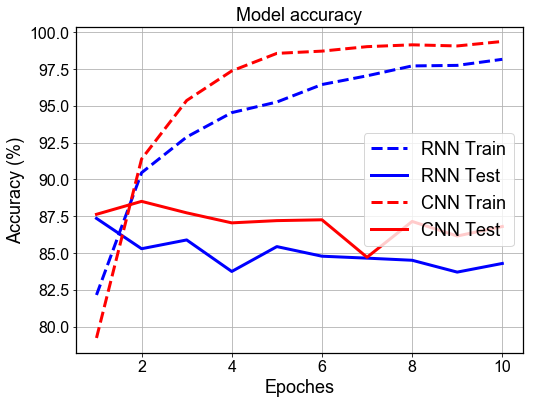

In [115]:
width1 = 3
color1, color2 = 'blue','red'
font1, font2, font3 = 18, 16, 18
plt.figure(figsize=(8,6))
plt.plot(epoches,history_RNN_train,'--',color = color1, linewidth= width1 )
plt.plot(epoches,history_RNN_test,color = color1, linewidth= width1)
plt.plot(epoches,history_CNN_train,'--',color = color2, linewidth= width1)
plt.plot(epoches,history_CNN_test,color = color2, linewidth= width1)
plt.title('Model accuracy', fontsize = font1)
plt.ylabel('Accuracy (%)', fontsize = font1)
plt.yticks(fontsize = font2)
plt.xlabel('Epoches', fontsize = font1)
plt.xticks(fontsize = font2)
plt.legend(['RNN Train', 'RNN Test','CNN Train', 'CNN Test'], fontsize = font3)
plt.grid()
plt.show()